# Dueling Prioritized Double Deep Q-Network (Dueling DDQN)

### 0.Background: from Prioritized DDQN to Dueling DDQN

The Dueling Prioritized Double Deep Q-Network (Dueling DDQN) builds upon the advancements of [Prioritized DDQN](./prioritized_ddqn_lunarlander.ipynb) by introducing a novel architecture known as **dueling networks**. While Prioritized DDQN enhances the efficiency of experience replay by prioritizing transitions with higher temporal-difference (TD) errors, and [Double DQN](./double_dqn_lunarlander.ipynb) addresses overestimation bias by decoupling action selection and evaluation, Dueling DDQN further improves the learning process by restructuring the Q-value estimation.

In a standard [DQN](./vanilla_dqn_lunarlander.ipynb) architecture, the network directly outputs Q-values for all actions. However, this approach treats the value of each state-action pair equally, which might not be optimal for states where the action does not significantly influence the overall value. Dueling networks address this limitation by separating the Q-value estimation into two components:
1. **State Value Function**: Represents the inherent value of being in a particular state, independent of the action.
2. **Advantage Function**: Captures the relative importance or "advantage" of taking a specific action in that state.

This separation allows the network to better generalize across states, particularly when the action's impact on the value is minimal.

---

#### Core Idea of Dueling Networks

The key innovation of dueling networks lies in their **two-stream architecture**:
- The initial layers, such as convolutional layers, are shared between the two streams and extract features from the input state.
- The network then splits into two branches:
  - One branch estimates the **state value function** $ V(s) $, which represents the overall value of the state.
  - The other branch estimates the **advantage function** $ A(s, a) $, which quantifies the relative importance of each action in the given state.
- Finally, the two outputs are combined to produce the Q-values for each action using the following equation:

$$
Q(s, a; \theta, \alpha, \beta) = V(s; \theta, \beta) + \left( A(s, a; \theta, \alpha) - \frac{1}{|\mathcal{A}|} \sum_{a'} A(s, a'; \theta, \alpha) \right)
$$

Here, the advantage function is normalized by subtracting its mean across all actions to ensure that $ Q(s, a) $ remains consistent.

#### Integrating Dueling Networks with Prioritized DDQN

When combined with **Prioritized Replay** and **Double DQN**, the Dueling architecture results in significant improvements:
- **Prioritized Replay** ensures that the most informative experiences are replayed more frequently, accelerating learning.
- **Double DQN** mitigates overestimation bias by decoupling action selection and evaluation.
- **Dueling Networks** enhance the network's ability to represent value functions and advantages, leading to more accurate Q-value estimations.

The combined architecture retains the same workflow as Prioritized DDQN, with the addition of the dueling network structure. It uses prioritized sampling from the replay buffer and updates the target network periodically, while the Q-value estimation now follows the dueling structure.


### 1. Import the Necessary Packages

In this notebook, we will implement a DQN agent with OpenAI Gym's LunarLander-v2 environment.

In [46]:
import random
import numpy as np

from collections import namedtuple, deque
import gymnasium as gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# for game rendering
import time
from PIL import Image
from IPython import display

from plot_utils import plot_scores

device = torch.device("cuda:0" if torch.cuda.is_available() else 
                      "mps" if torch.backends.mps.is_available() else 
                      "cpu")
print(f"Training on: {device}")

%matplotlib inline
%config InlineBackend.figure_format='retina'
np.set_printoptions(precision=3, linewidth=120)

Training on: mps


### 2. Explore Environment

<div style="text-align: center;">
    <img src="./images/lunar_lander.gif" alt="Mountain Car Environment" width="50%">
</div>

#### Discreate Action Space

There are four discrete actions available:

- 0: do nothing
- 1: fire left orientation engine
- 2: fire main engine
- 3: fire right orientation engine

#### Continuous Observation Space

The state is an 8-dimensional vector: 

- the coordinates of the lander in `x`
- the coordinates of the lander in`y`, 
- linear velocities in `x` 
- linear velocities in `y`, 
- its angle, 
- its angular velocity, and 
- a booleans that represent whether `left` leg is in contact with the ground or not.
- a booleans that represent whether `right` leg is in contact with the ground or not.

In [47]:
env = gym.make('LunarLander-v3', render_mode="rgb_array")

In [48]:
# Explore state (observation) space
print("State space:\n Continuous", env.observation_space.shape)
print(" - low:", env.observation_space.low)
print(" - high:", env.observation_space.high)

# Explore action space
print("Action space:\n", env.action_space)

print("-"*50)
# Generate some samples from the state space 
print("State space 10 samples:")
print(np.array([env.observation_space.sample() for i in range(10)]))

# Generate some samples from the action space
print("Action space 10 samples:")
print(np.array([env.action_space.sample() for i in range(10)]))

State space:
 Continuous (8,)
 - low: [ -2.5    -2.5   -10.    -10.     -6.283 -10.     -0.     -0.   ]
 - high: [ 2.5    2.5   10.    10.     6.283 10.     1.     1.   ]
Action space:
 Discrete(4)
--------------------------------------------------
State space 10 samples:
[[-0.142 -0.591 -7.455 -5.842 -3.935 -2.13   0.321  0.878]
 [-1.027 -2.244  0.19   1.184  0.457 -7.906  0.043  0.083]
 [-0.925 -0.51   0.443 -1.623  0.751  3.549  0.404  0.101]
 [ 1.101 -2.079 -4.527 -7.352 -1.157  9.784  0.875  0.161]
 [-1.915  1.172 -4.494 -0.909 -5.515 -1.256  0.86   0.149]
 [-2.084  0.076  6.869 -5.872 -1.707  6.653  0.982  0.225]
 [ 2.124 -1.83   7.394 -1.415 -3.286  1.475  0.848  0.366]
 [-0.031  1.836 -9.051 -9.156 -0.136  5.033  0.11   0.408]
 [-1.838 -1.158 -0.602 -1.432 -1.314  6.097  0.523  0.49 ]
 [-1.474 -0.656 -5.247  3.302 -0.827 -5.689  0.895  0.557]]
Action space 10 samples:
[2 0 3 3 3 1 2 1 3 0]


### 3. Define Replay Buffer

#### Using Prioritized Experience Replay Improve Training Stability

<div style="text-align: center;">
    <img src="./images/how-to-compute-probs.png" alt="Mountain Car Environment" width="70%">
</div>

When an agent interacts with the environment, the sequence of experience tuples can be highly correlated, which poses a risk for naive Q-learning algorithms. These algorithms, when learning sequentially from such correlated data, may lead to unstable updates, causing action values to oscillate or diverge.

To address this, a replay buffer is introduced to store experience tuples $(S, A, R, S')$ collected during interactions with the environment and priorities array with same size of buffer for probability. By using **prioritized experience replay**, small batches of tuples are **sampled from the buffer for training based on probability computed with priority value**. This sampling breaks harmful correlations, stabilizes learning, and allows the agent to:  
1. Reuse individual experience tuples multiple times.  
2. Recall rare events.  
3. Make better overall use of past experiences.  

Experience replay thus improves the efficiency and stability of the learning process.

In [49]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples with prioritization."""

    def __init__(self, action_size, buffer_size, batch_size, seed, alpha=0.6, beta=0.4, eps=1e-6):
        """
        Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
            alpha (float): hyperparameter to control the degree of prioritization
            beta (float): importance-sampling correction factor
            eps (float): small value to avoid zero priority
        """
        self.action_size = action_size
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.memory = deque(maxlen=buffer_size)
        self.experience = namedtuple(
            "Experience",
            field_names=["state", "action", "reward", "next_state", "done"],
        )
        self.seed = random.seed(seed)
        
        # Prioritization parameters
        self.alpha = alpha
        self.beta = beta
        self.eps = eps

        # Initialize with max priority
        self.max_priority = 1.0
        # Priority array
        self.priorities = np.zeros(buffer_size, dtype=np.float32)
        # Tracks the current index for inserting new experiences
        self.position = 0

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        
        # Add experience to memory
        if len(self.memory) < self.buffer_size:
            self.memory.append(e)
        else:
            self.memory[self.position] = e
        
        # Set the priority of the new experience to max priority
        self.priorities[self.position] = self.max_priority
        self.position = (self.position + 1) % self.buffer_size  # Circular buffer

    def _to_tensor(self, data, dtype=torch.float):

        """Convert numpy array to tensor with specified dtype and device in one operation"""
        return torch.from_numpy(np.vstack(data)).to(device=device, dtype=dtype)
    
    def update_priorities(self, indices, td_errors):
        """Update priorities of sampled experiences based on TD-errors."""
        self.priorities[indices] = np.abs(td_errors).squeeze() + self.eps
        # Update max priority
        self.max_priority = max(self.max_priority, max(self.priorities)) 

    def sample(self):
        """Sample a batch of experiences from memory based on priority."""

        # Calculate probabilities and only consider valid priorities
        priorities = self.priorities[:len(self.memory)]
        probs = priorities ** self.alpha
        # Normalize to get probabilities
        probs /= probs.sum()

        # Sample indices based on probabilities
        indices = np.random.choice(len(self.memory), size=self.batch_size, p=probs, replace=False)
        experiences = [self.memory[i] for i in indices]

        # Calculate importance-sampling weights
        total = len(self.memory)
        weights = (total * probs[indices]) ** (-self.beta)
        # Normalize weights to avoid instability
        weights /= weights.max()
        
        states, actions, rewards, next_states, dones = zip(*experiences)

        states = self._to_tensor(states)
        actions = self._to_tensor(actions, dtype=torch.long)
        rewards = self._to_tensor(rewards)
        next_states = self._to_tensor(next_states)
        dones = self._to_tensor(dones, dtype=torch.uint8)

        return (states, actions, rewards, next_states, dones, indices, weights)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [50]:
# Simulate Experience Replay How to Works
buffer = ReplayBuffer(action_size=env.action_space.n, buffer_size=10, batch_size=2, seed=42)
state, _ = env.reset()
for i in range(5):
	action = env.action_space.sample()
	next_state, reward, done, _, _ = env.step(action)
	buffer.add(state, action, reward, next_state, done)
print(f"Current Buffer Size: {len(buffer)}")
print("Sample one batch:")
batches = buffer.sample()
states, actions, rewards, next_states, dones,  indices, weights = batches
print(f" States Size: {states.shape}, \n Actions Size: {actions.shape}, "
	  f"\n Rewards Size: {rewards.shape}, \n Next States Size: {next_states.shape}"
	  f"\n Dones Size: {dones.shape}"
	  f"\n Indices: {indices.shape}, Weights: {weights.shape}"
)

Current Buffer Size: 5
Sample one batch:
 States Size: torch.Size([2, 8]), 
 Actions Size: torch.Size([2, 1]), 
 Rewards Size: torch.Size([2, 1]), 
 Next States Size: torch.Size([2, 8])
 Dones Size: torch.Size([2, 1])
 Indices: (2,), Weights: (2,)


### 4. Define Dueling Q Network

#### Using Dueling Networks as Approximators for Q values

<div style="text-align: center;">
    <img src="./images/model-view.png" alt="Mountain Car Environment" width="70%">
</div>

This image shows the transition from a **Traditional Q Table** to a **Parameterized Q Function** in reinforcement learning. 

The Q table (left) stores discrete Q-values $ Q(s_t, a_t) $ for each state-action pair but struggles with scalability in high-dimensional spaces. The parameterized Q function (right) replaces the table with a neural network $ Q(s_t, a_t; w) $, where $ w $ are the network's parameters.

#### <span style="color: red;">Update: </span> Dueling Network Architecture

The **Dueling Q Network** modifies the traditional Q-network architecture by introducing two separate streams after the shared feature extraction layers (e.g., convolutional layers):

1. **State Value Stream**: Estimates the state value function $ V(s; w, \beta) $, which represents the overall value of being in a specific state, independent of the action.
2. **Advantage Stream**: Estimates the advantage function $ A(s, a; w, \alpha) $, which quantifies the relative importance of taking a specific action in the given state.

The outputs of these two streams are combined to compute the Q-values for each action using the following equation:
$$
Q(s, a; w, \alpha, \beta) = V(s; w, \beta) + \left( A(s, a; w, \alpha) - \frac{1}{|\mathcal{A}|} \sum_{a'} A(s, a'; w, \alpha) \right)
$$

This architecture improves the stability and efficiency of Q-value estimation by separating the representation of state values and action advantages.

<div style="text-align: center;">
    <img src="./images/dueling-networks.png" width="70%">
</div>


In [51]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, hidden_size=64, seed=42):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.Q_w = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        self.Q_alpha = nn.Linear(hidden_size, action_size)
        self.Q_beta = nn.Linear(hidden_size, 1)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        output = self.Q_w(state)
        actions = self.Q_alpha(output)
        values = self.Q_beta(output)
        actions = values + (actions - actions.mean(dim=-1, keepdim=True))
        return actions


# test model
q_net = QNetwork(8, 4, 16, seed=42)
# fake input, by given batch size 4
states = torch.rand((4, 8))
# fake output size
print(q_net(states).shape)

torch.Size([4, 4])


### 5. Define Agent

##### How to Learn in Prioritized DDQN

<div style="text-align: center;">
    <img src="./images/dqn-gradient-descent.png" alt="Mountain Car Environment" width="70%">
</div>

This image provides a visual summary of the core theory and update mechanism of **Deep Q-Network (DQN)**, showcasing the key formula derivations from **Q-Learning** to **DQN**, as well as how neural networks are used to approximate and update Q-values.

---

**1. Core Idea Based on the Bellman Equation**
- **Bellman Equation:**
  $$
  Q^*(s_t, a_t) = R_t + \gamma \max_a Q^*(s_{t+1}, a)
  $$
  - This states that the optimal Q-value for the current state-action pair equals the immediate reward $ R_t $ plus the discounted maximum Q-value of the next state.
  - The core objective of DQN is to approximate this equation using a neural network.

**2. Derivation from Q-Learning to DQN**
- **Q-Learning Update Formula:**
  $$
  Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left( R_t + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t) \right)
  $$
  - **TD Target:**
    $$
    R_t + \gamma \max_a Q(s_{t+1}, a)
    $$
    This represents the target Q-value for the current state, combining the immediate reward $ R_t $ and the maximum Q-value of the next state.
  - **Current Value:**
    $$
    Q(s_t, a_t)
    $$
    This is the current estimated Q-value.
  - **TD Error:**
    $$
    \delta_t = \left( R_t + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t) \right)
    $$
    This measures the difference between the target Q-value and the current Q-value.

- **Neural Network Introduction:**
  - To handle continuous state spaces, DQN replaces the traditional Q-table with a neural network $ Q(s, a; w) $, where $ w $ represents the network parameters.
  - The goal is to optimize the network so that its output $ Q(s, a; w) $ approximates the true $ Q^*(s, a) $.


**3. Loss Function and Gradient Update in DQN**
- **Loss Function:**
  $$
  L(w) = \frac{1}{2} \left[ Q(s_t, a_t; w) - Q^*(s_t, a_t) \right]^2
  $$
  - Here, $ Q^*(s_t, a_t) $ is the target Q-value (TD Target) calculated using the Bellman equation.
  - The loss function minimizes the squared error between the network's output $ Q(s_t, a_t; w) $ and the target Q-value $ Q^*(s_t, a_t) $.

- **Gradient Calculation:**
  $$
  \nabla_w L(w) = \left( Q(s_t, a_t; w) - Q^*(s_t, a_t) \right) \nabla_w Q(s_t, a_t; w)
  $$
  - The gradient consists of two parts:
    1. The error term: $ Q(s_t, a_t; w) - Q^*(s_t, a_t) $
    2. The gradient of the network output: $ \nabla_w Q(s_t, a_t; w) $

- **Weight Update:**
  $$
  w \leftarrow w - \alpha \nabla_w L(w)
  $$
  - Using gradient descent, the network parameters $ w $ are updated to reduce the loss function.

- **Final DQN Update Formula:**
  $$
  L(w) = \frac{1}{2} \left[ Q(s_t, a_t; w) - (R_t + \gamma \max_a Q(s_{t+1}, a; w^-)) \right]^2
  $$

  $$
  w' \leftarrow w + \alpha \left( R_t + \gamma \max_a Q(s_{t+1}, a; w^-) - Q(s_t, a_t; w) \right) \nabla_w Q(s_t, a_t; w)
  $$
  - Here, $ w^- $ represents the fixed target network parameters during the learning step, which are used to stabilize training.




- <span style="color: red;">Update: </span> **Using Double DQN to replace TD target**

$$
R_t + \gamma Q(S_{t+1}, \arg\max_a Q(S_{t+1}, a, w), w^-)
$$

- <span style="color: red;">Update: </span> **Using importance-sampling weights to correct for the bias introduced by prioritized sampling**

$$
w' \leftarrow w + \alpha  (\frac{1}{K \cdot P_t})^b \cdot \delta_t \cdot \nabla_w Q(s_t, a_t; w)
$$
  - $ K $: Total number of experiences in the replay buffer.
  - $ P_t $: Sampling probability of the $ t $-th experience.
  - $ b $: Hyperparameter that controls the amount of importance sampling correction.
  - $ \delta_t $: TD error for the $ t $-th experience.
  - $ α $: Learning rate.


#### Psedocode in Paper


<div style="text-align: center;">
    <img src="./images/prioritized-ddqn-psedocode.png" alt="Mountain Car Environment" width="70%">
</div>


In [52]:
class Agent:
    """Interacts with and learns from the environment."""

    def __init__(
        self,
        env,
        hidden_size=64,
        buffer_size=int(1e5),
        batch_size=64,
        gamma=0.99,
        alpha=1e-3,
        lr=5e-4,
        update_step=4,
        seed=42,
        a=0.6,
        b=0.4
    ):
        """Initialize an Agent object.

        Params
        ======
            buffer_size (int): replay buffer size
            batch_size (int): minibatch size
            lr (float): learning rate
            gamma (float): discount factor
            alpha (float): soft update of target parameters
            update_step (int): how often to update the network
            seed (int): random seed
            a (float): hyperparameter that controls the amount of prioritization when sampling
            b (float): hyperparameter that controls the amount of importance sampling correction

        """
        self.seed = random.seed(seed)

        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.lr = lr
        self.gamma = gamma
        self.alpha = alpha
        self.update_step = update_step
        self.a = a
        self.b = b

        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n

        # Q-Network
        self.Q = QNetwork(self.state_size, self.action_size, hidden_size, seed).to(device)
        self.Q_target = QNetwork(self.state_size, self.action_size, hidden_size, seed).to(device)
        self.optimizer = optim.Adam(self.Q.parameters(), lr=self.lr)

        # Replay memory
        self.memory = ReplayBuffer(
            self.action_size, self.buffer_size, self.batch_size, seed, alpha=self.a, beta=self.b
        )
        # Initialize time step (for updating every update step)
        self.t_step = 0

    def __repr__(self):
        return (
            f"Q Network Arch: {self.Q}\n"
            f"State space size: {self.state_size}\n"
            f"Action space size: {self.action_size}\n"
            f"Current Memory size: {len(self.memory)}"
        )

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every update_step time steps.
        self.t_step = (self.t_step + 1) % self.update_step
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)

    def select_action(self, state, epsilon=0.0):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.Q.eval()
        with torch.no_grad():
            actions = self.Q(state)
        self.Q.train()

        # Epsilon-greedy action selection
        if random.random() > epsilon:
            return np.argmax(actions.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        self.optimizer.zero_grad()

        # Unpack experiences
        states, actions, rewards, next_states, dones, indices, weights = experiences
        # Convert weights to PyTorch tensor
        weights = torch.tensor(weights, dtype=torch.float, device=device).reshape(-1, 1)
        
        # [UPDATE] compute td targets using target network and current network
        with torch.no_grad():
            best_actions = torch.argmax(self.Q(next_states), dim=-1, keepdim=True)
            Q_next = torch.gather(self.Q_target(next_states), dim=-1, index=best_actions)

        Q_targets = rewards + (1-dones) * self.gamma * Q_next
        
        # compute curr values using local network
        Q_expected = torch.gather(self.Q(states), dim=-1, index=actions)
    
        # compute mean squared loss using td error
        td_error = Q_expected - Q_targets
        
        # Update priorities in memory
        self.memory.update_priorities(indices, td_error.detach().cpu().numpy())

        # Compute loss with importance-sampling weights
        loss = (weights * (td_error ** 2)).mean()
        loss.backward()
        
        # update local network parameters
        self.optimizer.step()

        # update target network parameters
        self.soft_update()

    def soft_update(self):
        """Soft update model parameters.
        θ_target = alpha*θ + (1 - alpha)*θ_target
        =>
        θ_target = θ_target + alpha*(θ - θ_target)

        Params
        ======
            Q (PyTorch model): weights will be copied from
            Q_target (PyTorch model): weights will be copied to
            alpha (float): interpolation parameter
        """
        for target_param, local_param in zip(
            self.Q_target.parameters(), self.Q.parameters()
        ):
            target_param.data.copy_(
                target_param.data + self.alpha * (local_param.data - target_param.data)
            )
    
    def hard_update(self):
        """Hard update: θ_target = θ"""
        for target_param, local_param in zip(
            self.Q_target.parameters(), self.Q.parameters()
        ):
            target_param.data.copy_(local_param.data)


In [53]:
agent = Agent(
	env,
	buffer_size=int(1e5),
	batch_size=64,
	gamma=0.99,
	alpha=1e-3,
	lr=5e-4,
	update_step=4,
	seed=42,
)
agent

Q Network Arch: QNetwork(
  (Q_w): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (Q_alpha): Linear(in_features=64, out_features=4, bias=True)
  (Q_beta): Linear(in_features=64, out_features=1, bias=True)
)
State space size: 8
Action space size: 4
Current Memory size: 0

### 6. Check Random Agent

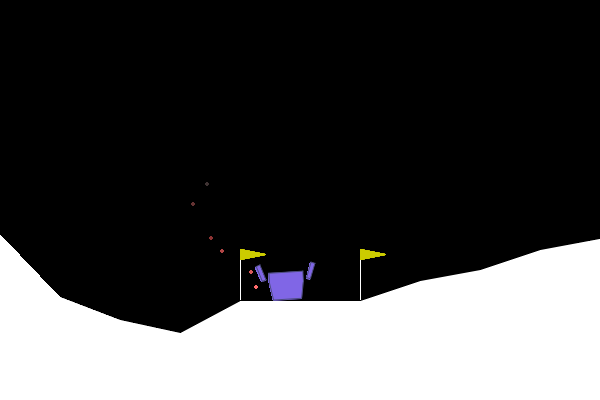

In [54]:
state, info = env.reset(seed=505)
for t in range(100):
    # clear frame
    display.clear_output(wait=True)

    action = agent.select_action(state)

    # render game
    frame = env.render()
    display.display(Image.fromarray(frame))
    time.sleep(0.05)

    state, reward, done, _, info = env.step(action)
    if done:
        break
        
env.close()

### 7. Train the Agent with DQN

In [55]:
def dueling_ddqn(
    env,
    agent,
    n_episodes=2000,
    window=100,
    max_t=1000,
    epsilon=1.0,
    eps_min=0.01,
    eps_decay=0.995,
):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        epsilon (float): starting value of epsilon, for epsilon-greedy action selection
        eps_min (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    # list containing scores from each episode
    scores = []
    max_avg_score = -np.inf
    for i_episode in range(1, n_episodes + 1):

        # get init state
        state, _ = env.reset()

        # run each episode
        total_reward = 0
        for t in range(max_t):
            action = agent.select_action(state, epsilon)
            next_state, reward, done, _, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                break

        # save current episode total score
        scores.append(total_reward)

        # Update epsilon
        epsilon = max(eps_min, eps_decay * epsilon)  # decrease epsilon

        # Print episode stats
        if len(scores) > window:
            avg_score = np.mean(scores[-window:])
            if avg_score > max_avg_score:
                max_avg_score = avg_score

        newline = "\n" if i_episode % window == 0 else ""
        print(
            f"\rEpisode {i_episode}/{n_episodes} | Max Average Score: {max_avg_score:.2f}",
            end=newline,
        )

        if max_avg_score >= 200.0:
            print(
                f"\nEnvironment solved in {i_episode - 100:d} episodes!\tAverage Score: {max_avg_score:.2f}"
            )
            torch.save(agent.Q.state_dict(), "checkpoint.pth")
            break
    return scores


scores = dueling_ddqn(
    env,
    agent,
    n_episodes=2000,
    window=100,
    max_t=10000,
    epsilon=1.0,
    eps_min=0.01,
    eps_decay=0.995,
)

Episode 100/2000 | Max Average Score: -inf
Episode 200/2000 | Max Average Score: -142.75
Episode 300/2000 | Max Average Score: -26.323
Episode 400/2000 | Max Average Score: 137.43
Episode 493/2000 | Max Average Score: 200.65
Environment solved in 393 episodes!	Average Score: 200.65


0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
488    196.770760
489    198.021095
490    197.550738
491    197.525761
492    200.645927
Length: 493, dtype: float64

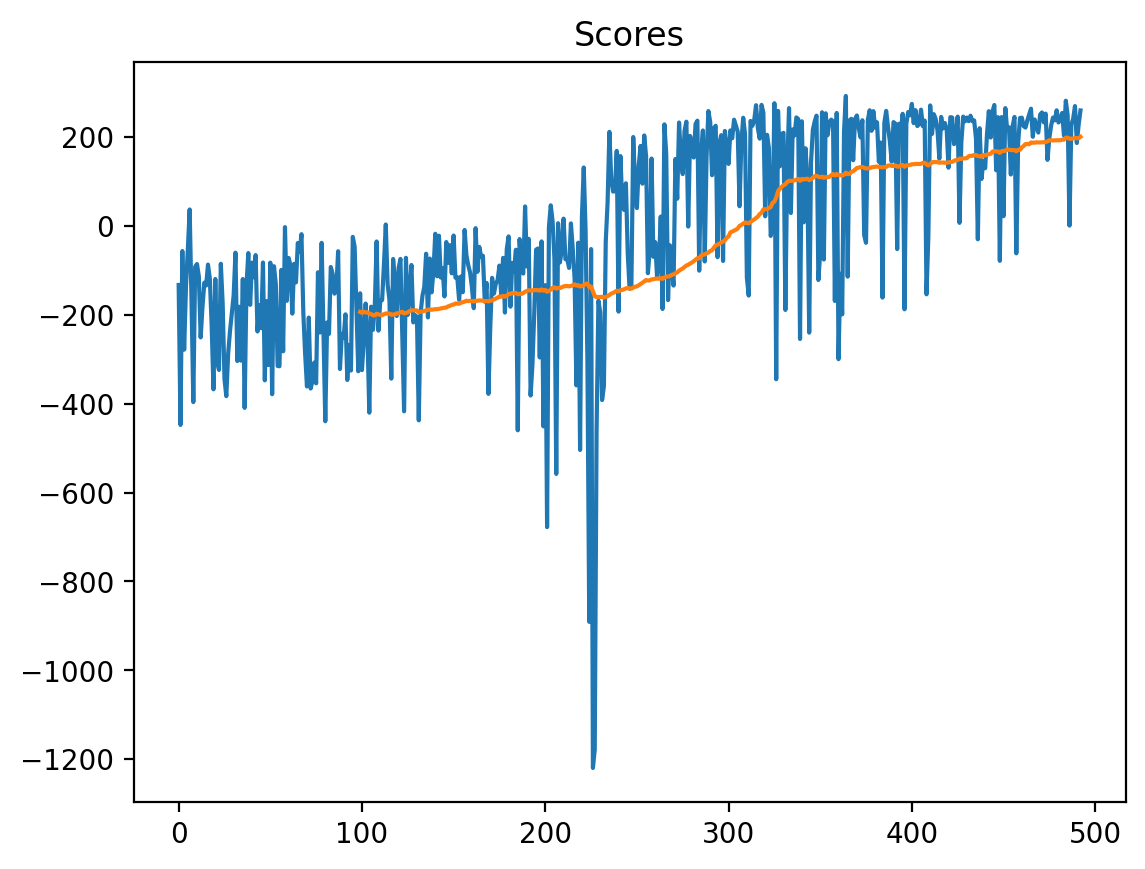

In [56]:
plot_scores(scores)

### 8. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

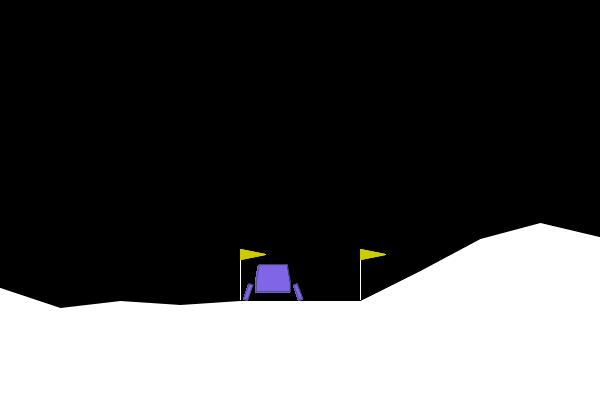

Final score: 263.07848997002526
Average score: 219.6135942102675


In [57]:
# load the weights from file
agent.Q.load_state_dict(torch.load('checkpoint.pth'))

env = gym.make("LunarLander-v3", render_mode="rgb_array")

avg_score = 0
for i in range(3):
	state, info = env.reset()
	total_reward = 0
	for t in range(500):
		# clear frame
		display.clear_output(wait=True)

		action = agent.select_action(state)

		# render game
		frame = env.render()
		display.display(Image.fromarray(frame))
		time.sleep(0.05)

		state, reward, done, _, info = env.step(action)
		total_reward += reward
		if done:
			break
	
	avg_score += total_reward
	print('Final score:', total_reward)
env.close()
print(f"Average score: {avg_score / 3}")